In [1]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import sqlite3
import pandas as pd
from House_Price_Analysis import RealEstateStats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from House_Price_Prediction import LinearRegressionModel

In [27]:

url_classes = {
        'https://www.zillow.com/new-york-ny/':{
            'price_tag':'span',
            'price_class':'PropertyCardWrapper__StyledPriceLine-srp-8-105-0__sc-16e8gqd-1 dHAgxu',
            'location_tag':'a',
            'location_class':'StyledPropertyCardDataArea-c11n-8-105-0__sc-10i1r6-0 golejz property-card-link',
            'details_tag': 'ul',
            'details_class': 'StyledPropertyCardHomeDetailsList-c11n-8-105-0__sc-1j0som5-0 ldtVy'
        },
        'https://www.zillow.com/homes/LosAngeles/':{
            'price_tag':'span',
            'price_class':'PropertyCardWrapper__StyledPriceLine-srp-8-105-0__sc-16e8gqd-1 dHAgxu',
            'location_tag':'a',
            'location_class':'StyledPropertyCardDataArea-c11n-8-105-0__sc-10i1r6-0 golejz property-card-link',
            'details_tag': 'ul',
            'details_class': 'StyledPropertyCardHomeDetailsList-c11n-8-105-0__sc-1j0som5-0 ldtVy'
        },
        'https://www.zillow.com/chicago-il/':{
            'price_tag':'span',
            'price_class':'PropertyCardWrapper__StyledPriceLine-srp-8-105-0__sc-16e8gqd-1 dHAgxu',
            'location_tag':'a',
            'location_class':'StyledPropertyCardDataArea-c11n-8-105-0__sc-10i1r6-0 golejz property-card-link',
            'details_tag': 'ul',
            'details_class': 'StyledPropertyCardHomeDetailsList-c11n-8-105-0__sc-1j0som5-0 ldtVy'
        }
    }

def scrape_and_save_data(url, csv_filename):
    classes = url_classes[url]
    price_tag = classes['price_tag']
    price_class = classes['price_class']
    location_tag = classes['location_tag']
    location_class = classes['location_class']
    details_tag = classes['details_tag']
    details_class = classes['details_class']


    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))


    driver.get(url)
    driver.implicitly_wait(10)
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    driver.quit()


    prices = soup.find_all(price_tag, class_=price_class)
    locations = soup.find_all(location_tag, class_=location_class)
    details = soup.find_all(details_tag, class_=details_class)

    bedrooms_list = []
    area_list = []
    for detail in details:
        text = detail.get_text(strip=True)
        bedrooms = text.split('bds')[0].strip() if 'bds' in text else None
        area = text.split('sqft')[0].split('ba')[-1].strip().replace(',', '') if 'sqft' in text else None
        bedrooms_list.append(bedrooms)
        area_list.append(area)

    #add to dataframe
    data = {
        'Price': [p.text for p in prices],
        'Location': [l.text for l in locations],
        'Bedrooms': bedrooms_list,
        'Area': area_list
    }
    df = pd.DataFrame(data)

    #clean data
    df['Price']=df['Price'].str.replace('$','').str.replace(',','').str.extract('(\\d+)').astype(float)
    df['Location']=df['Location'].str.strip()
    df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
    df['Area'] = pd.to_numeric(df['Area'], errors='coerce')

    df = df.dropna(subset=['Price', 'Location', 'Bedrooms', 'Area'])

    df.to_csv(csv_filename, mode='a', header=False, index=False)

scrape_and_save_data('https://www.zillow.com/chicago-il/', 'test_Houses_Prices.csv')

In [2]:

df = pd.read_csv('USA_Houses_Prices.csv', header=None, names=['Price','Location','Bedrooms','Area'])

#connect to SQLite database
conn = sqlite3.connect('usa_houses_prices.db')
cursor = conn.cursor()

#create table
cursor.execute('''
        create table if not exists Houses(
               ID integer primary key autoincrement,
               Price float,
               Location text,
               Bedrooms int,
               Area float
               )
'''
)

#write the dataframe to the SQLite table
df.to_sql('Houses', conn, if_exists='append',index=False)

conn.commit
conn.close

<function Connection.close()>

In [2]:
conn = sqlite3.connect('usa_houses_prices.db')
cursor = conn.cursor()

query = '''
    SELECT
        CASE
            WHEN Location LIKE '%Los Angeles, CA%' THEN 'Los Angeles, CA'
            WHEN Location LIKE '%, NY%' THEN 'New York, NY'
            WHEN Location LIKE '%Chicago, IL%' THEN 'Chicago, IL' 
        END AS City, 
        AVG(Price) AS avg_price, 
        MIN(Price) AS min_price, 
        MAX(Price) AS max_price, 
        COUNT(*) AS num_properties 
    FROM Houses
    WHERE Location LIKE '%Los Angeles, CA%'
        OR Location LIKE '%, NY%'
        OR Location LIKE '%Chicago, IL%'
    GROUP BY City
       
'''

df = pd.read_sql_query(query,conn)

styled_df = df.reset_index(drop=True).style.format(precision=6)

styled_df

,City,avg_price,min_price,max_price,num_properties
0,"Chicago, IL",415067.392857,149900.000000,1300000.000000,28
1,"Los Angeles, CA",18010185.714286,189000.000000,137500000.000000,21
2,"New York, NY",12599996.939394,99000.000000,150000000.000000,33


In [3]:

def load_data_from_db(db_path, query):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

query = '''
    SELECT *
    FROM Houses
'''

def main():
    db_path = 'usa_houses_prices.db'
    df = load_data_from_db(db_path, query)
    
    stats = RealEstateStats(df)
    
    print("Thống kê mô tả cho giá bất động sản:")
    print(stats.describe_price())
    
    print(f"Giá trị trung bình: {stats.mean_price()}")
    print(f"Trung vị: {stats.median_price()}")
    print(f"Độ lệch chuẩn: {stats.std_price()}")
    print(f"Giá trị nhỏ nhất: {stats.min_price()}")
    print(f"Giá trị lớn nhất: {stats.max_price()}")
    print(f"Phân vị thứ 25%: {stats.percentile_25()}")
    print(f"Phân vị thứ 75%: {stats.percentile_75()}")
    print(f"Hệ số biến thiên giá: {stats.coefficient_of_variation()}")
    print(stats.count_by_area())
    print(stats.outlier_analysis())
    print(stats.price_frequency())

    if 'Area' in df.columns:
        print(f"Hệ số tương quan giữa giá và diện tích: {stats.correlation_price_area()}")
    
       
if __name__ == "__main__":
    main()

Thống kê mô tả cho giá bất động sản:
count            99.00
mean     10,798,460.95
std      30,968,434.25
min          99,000.00
25%         349,950.00
50%         649,000.00
75%       1,399,500.00
max     150,000,000.00
Name: Price, dtype: float64
Giá trị trung bình: 10798460.949494949
Trung vị: 649000.0
Độ lệch chuẩn: 30968434.249626335
Giá trị nhỏ nhất: 99000.0
Giá trị lớn nhất: 150000000.0
Phân vị thứ 25%: 349950.0
Phân vị thứ 75%: 1399500.0
Hệ số biến thiên giá: 2.867856298639923
Location
170 Maple Pkwy, Staten Island, NY 10303          1
60 Seguine Pl, Staten Island, NY 10312           1
115-30 116th St, South Ozone Park, NY 11420      1
169 Taylor St, Staten Island, NY 10310           1
594 Eastern Pkwy, Brooklyn, NY 11225             1
                                                ..
6551 N Damen Ave #1, Chicago, IL 60626           1
1422 N Hoyne Ave #1, Chicago, IL 60622           1
5150 S King Dr APT A1, Chicago, IL 60615         1
9841 S Leavitt St, Chicago, IL 60643      

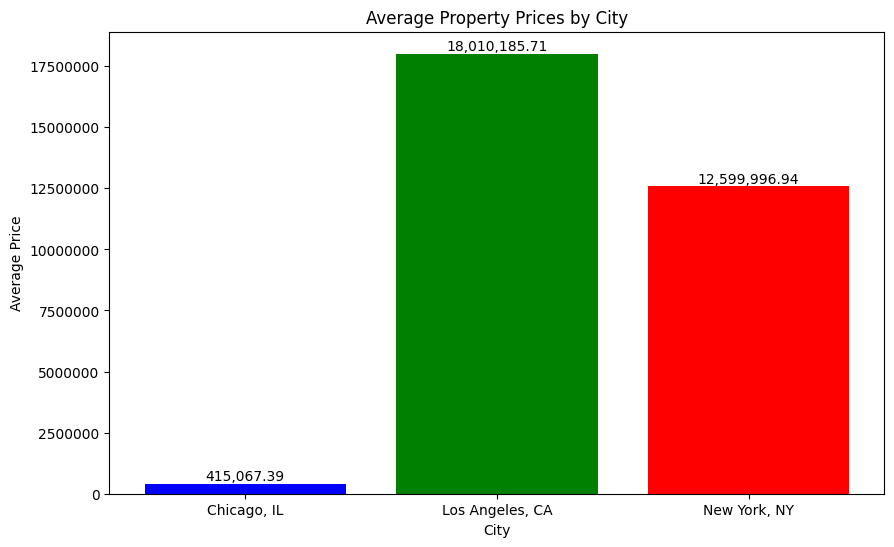

In [4]:
query = '''
    SELECT
        CASE
            WHEN Location LIKE '%Los Angeles, CA%' THEN 'Los Angeles, CA'
            WHEN Location LIKE '%, NY%' THEN 'New York, NY'
            WHEN Location LIKE '%Chicago, IL%' THEN 'Chicago, IL' 
        END AS City, 
        Price,
        AVG(Price) AS avg_price, 
        MIN(Price) AS min_price, 
        MAX(Price) AS max_price, 
        COUNT(*) AS num_properties 
    FROM Houses
    WHERE Location LIKE '%Los Angeles, CA%'
        OR Location LIKE '%, NY%'
        OR Location LIKE '%Chicago, IL%'
    GROUP BY City
       
'''
df = pd.read_sql_query(query, conn)
plt.figure(figsize=(10, 6))
bars = plt.bar(df['City'], df['avg_price'], color=['blue', 'green', 'red'])
plt.xlabel('City')
plt.ylabel('Average Price')
plt.title('Average Property Prices by City')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.2f}', ha='center', va='bottom')

plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.gca().ticklabel_format(style='plain', axis='y')

plt.show()

Mean Squared Error: 289605903412705.0
R^2 Score: 0.6949450805850086


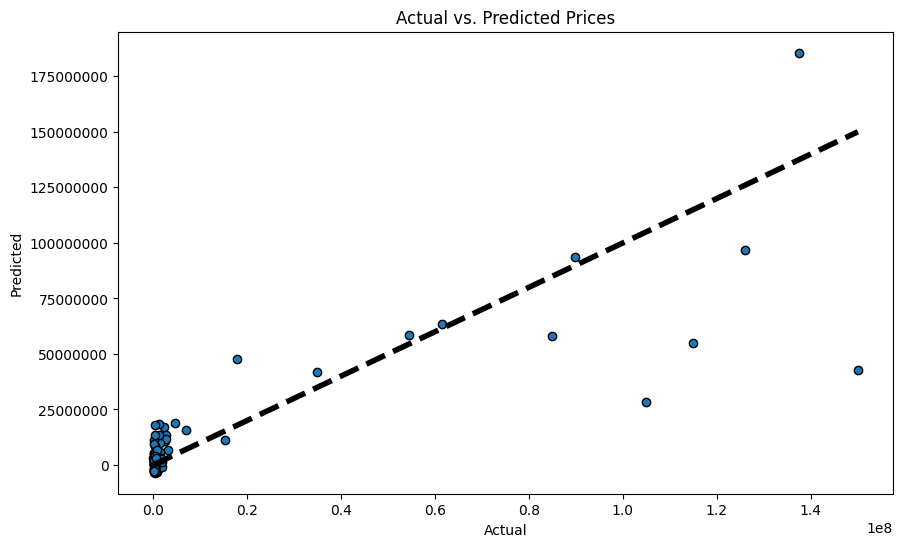

          Coefficient
Area         2,838.38
Bedrooms 2,539,123.46


In [5]:
# Define database path and query to load data
db_path = 'usa_houses_prices.db'
query = '''
    SELECT Area, Bedrooms, Price
    FROM Houses
'''

# Define predictor variables and target variable
predictors = ['Area', 'Bedrooms']
target = 'Price'

# Initialize and use the LinearRegressionModel class
model = LinearRegressionModel(db_path, query, predictors, target)
model.train_model()

# Evaluate the model
mse, r2 = model.evaluate_model()
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot actual vs. predicted prices
model.plot_predictions()

# Print coefficients
coefficients = model.get_coefficients()
print(coefficients)